In [1]:
import random
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
from predict import load_trained_model, predict_image_class
from data_preparation import get_cifar10_datasets, get_dataloader
from train import train_model

# Functions

In [3]:
def plot_triplet_images(image_label_tuple, index_to_class_mapping):
    """
    Plots a row of 3 CIFAR-10 images with labels.

    Args:
        image_label_tuple (tuple): A tuple of (images, labels) where:
            - images is a list or tensor of 3 images
            - labels is a list or tensor of 3 corresponding labels
        index_to_class_mapping (dict): Mapping from class index to class name
    """
    images, labels = image_label_tuple
    assert len(images) == 3

    label_title = ['anchor', 'positive', 'negative']
    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    for i in range(3):
        img, label = images[i], labels
        if i == 2:
            display_label = 'other'
        else:
            display_label = index_to_class_mapping[label]

        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
            if img.shape[0] == 3:  # (C, H, W)
                img = img.permute(1, 2, 0)  # to (H, W, C)
        
        axs[i].imshow(img)
        axs[i].set_title(label_title[i] + ': ' + display_label, fontsize=10)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
def show_image(image_tensor, title=None):
    assert isinstance(image_tensor, torch.Tensor), "Input must be a torch.Tensor"
    assert image_tensor.shape == (3, 32, 32), "Image must be of shape (3, 32, 32)"

    # Move to CPU, detach, and convert to numpy
    img = image_tensor.detach().cpu()
    img = img.permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # Rescale from normalized range [-1, 1] or other to [0, 1] if needed
    img = (img - img.min()) / (img.max() - img.min())

    # Plot the image
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


In [5]:
def reduce_dimension_pca(embeddings: np.ndarray, target_dim: int = 2) -> np.ndarray:
    pca = PCA(n_components=target_dim)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

In [6]:
def sample_per_class(data: np.ndarray, labels: np.ndarray, num_samples_per_class: int):
    unique_classes = np.unique(labels)
    sampled_indices = []

    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]

        num_to_sample = min(num_samples_per_class, len(class_indices))

        sampled_class_indices = np.random.choice(class_indices, size=num_to_sample, replace=False)

        sampled_indices.extend(sampled_class_indices)

    sampled_indices = np.array(sampled_indices)
    np.random.shuffle(sampled_indices)

    sampled_data = data[sampled_indices]
    sampled_labels = labels[sampled_indices]

    return sampled_data, sampled_labels

# Dataset

In [7]:
CLASS_INDEX = [0, 1, 2, 3]
CLASS_LABEL = ['cat', 'dog', 'ship', 'truck']
LABEL_MAP = {original_label: new_label for new_label, original_label in enumerate(CLASS_INDEX)}
INDEX_TO_CLASS = {i: j for i, j in zip(CLASS_INDEX, CLASS_LABEL)}

In [8]:
train_dataset, test_dataset = get_cifar10_datasets(data_dir='./data')
train_loader, test_loader = get_dataloader(train_dataset, test_dataset, batch_size=128, num_workers=8)

Filtering and remapping base training dataset...
Dataset filtered. New number of samples: 20000
Filtering and remapping base testing dataset...
Dataset filtered. New number of samples: 4000
Triplet Dataset created with 20000 samples (based on base dataset size).
Classes found in dataset: [0, 1, 2, 3]
Filtered CIFAR-10 Triplet train loader and standard test loader created with 8 workers.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.7537313].


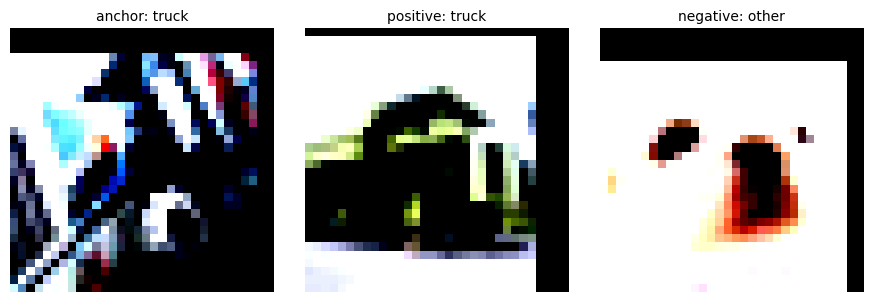

In [9]:
plot_triplet_images(train_dataset[random.randint(0, 20000)], INDEX_TO_CLASS)

# Training

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='cnn',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=0.5,
    triplet_weight=1,
    classification_weight=0.5,
)

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='cnn',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='cnn',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1.5,
    triplet_weight=1,
    classification_weight=0.5,
)

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='resnet18',
    embedding_dim=128,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='resnet18',
    embedding_dim=64,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1,
    triplet_weight=1,
    classification_weight=0.5,
)

In [ ]:
train_model(
    train_loader=train_loader,
    test_loader=test_loader,
    encoder_name='resnet18',
    embedding_dim=64,
    num_classes=4,
    learning_rate=0.0005,
    num_epochs=12,
    triplet_margin=1.5,
    triplet_weight=1,
    classification_weight=0.5,
)

# Predict

In [10]:
DEVICE = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [11]:
model = load_trained_model('./output/resnet18_4cls_64dim_1tm_model.pth', 'resnet18', 64, 4, DEVICE)

Model loaded successfully from ./output/resnet18_4cls_64dim_1tm_model.pth


In [ ]:
labels = []
embeddings = []
for image, label in test_dataset:
    label, prob, embedding = predict_image_class(model, image, DEVICE, True)
    labels.append(label)
    embeddings.append(embedding[0].cpu().detach().numpy())
len(labels)

In [ ]:
labels = np.array(labels)
embeddings = np.array([i for i in embeddings])

# Visualization

In [ ]:
reduced_embeddings = reduce_dimension_pca(embeddings)

In [ ]:
reduced_embeddings, labels = sample_per_class(reduced_embeddings, labels, 500)

In [ ]:
color_map = {
    'cat': 'green',
    'dog': 'blue',
    'ship': 'red',
    'truck': 'orange'
}
colors = [color_map[i] for i in labels]

In [ ]:
plt.figure(figsize=(10, 8))
for i in np.unique(labels):
    index = np.where(labels==i)[0]
    x = reduced_embeddings[index, 0]
    y = reduced_embeddings[index, 1]
    color = color_map[i]
    label = i
    plt.scatter(x, y, c=color, label=label, alpha=0.7)
plt.title("2D Embedding Visualization (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()